In [1]:
import mlrun
import os
import sagemaker
import boto3

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /User/.config/sagemaker/config.yaml


In [72]:
# Set the base project name
project_name = 'sagemaker-payment'

In [73]:
project.set_secrets(file_path="env.var")

In [74]:
project = mlrun.get_or_create_project(project_name, "./", user_project=True)

> 2024-01-24 11:54:12,501 [info] Project loaded successfully: {'project_name': 'sagemaker-payment'}


In [154]:
# Getting our model training function
train = project.set_function('./src/train.py', requirements=['sagemaker'],
                     name='train', kind='job', image='mlrun/mlrun')

In [165]:
evaluate_function = project.set_function(
    "src/evaluate.py",
    "evaluate",
    handler="evaluate",
    image="mlrun/mlrun",
    requirements=["xgboost"],
)

In [77]:
# Serving
serving_function = project.set_function(
    func="src/serving.py",
    name="serving",
    kind="serving",
    image="mlrun/mlrun",
    requirements=["xgboost"],
)

In [78]:
project.build_function("train")

> 2024-01-24 11:54:30,973 [info] Started building image: .mlrun/func-sagemaker-payment-yoni-train:latest


The `overwrite_build_params` parameter default will change from 'False' to 'True in 1.8.0.


INFO[0000] Retrieving image manifest mlrun/mlrun:1.6.0-rc21 
INFO[0000] Retrieving image mlrun/mlrun:1.6.0-rc21 from registry index.docker.io 
INFO[0000] Built cross stage deps: map[]                
INFO[0000] Retrieving image manifest mlrun/mlrun:1.6.0-rc21 
INFO[0000] Returning cached image manifest              
INFO[0000] Executing 0 build triggers                   
INFO[0000] Building stage 'mlrun/mlrun:1.6.0-rc21' [idx: '0', base-idx: '-1'] 
INFO[0000] Unpacking rootfs as cmd RUN echo 'Installing /empty/requirements.txt...'; cat /empty/requirements.txt requires it. 
INFO[0036] ARG AWS_ACCESS_KEY_ID=$AWS_ACCESS_KEY_ID     
INFO[0036] ARG AWS_DEFAULT_REGION=$AWS_DEFAULT_REGION   
INFO[0036] ARG AWS_SECRET_ACCESS_KEY=$AWS_SECRET_ACCESS_KEY 
INFO[0036] ARG SAGEMAKER-ROLE=$SAGEMAKER-ROLE           
INFO[0036] RUN echo 'Installing /empty/requirements.txt...'; cat /empty/requirements.txt 
INFO[0036] Initializing snapshotter ...                 
INFO[0036] Taking snapshot of full files

BuildStatus(ready=True, outputs={'image': '.mlrun/func-sagemaker-payment-yoni-train:latest'})

In [79]:
project.build_function("evaluate")

> 2024-01-24 11:56:30,409 [info] Started building image: .mlrun/func-sagemaker-payment-yoni-evaluate:latest


The `overwrite_build_params` parameter default will change from 'False' to 'True in 1.8.0.


INFO[0000] Retrieving image manifest mlrun/mlrun:1.6.0-rc21 
INFO[0000] Retrieving image mlrun/mlrun:1.6.0-rc21 from registry index.docker.io 
INFO[0000] Built cross stage deps: map[]                
INFO[0000] Retrieving image manifest mlrun/mlrun:1.6.0-rc21 
INFO[0000] Returning cached image manifest              
INFO[0000] Executing 0 build triggers                   
INFO[0000] Building stage 'mlrun/mlrun:1.6.0-rc21' [idx: '0', base-idx: '-1'] 
INFO[0000] Unpacking rootfs as cmd RUN echo 'Installing /empty/requirements.txt...'; cat /empty/requirements.txt requires it. 
INFO[0035] ARG AWS_ACCESS_KEY_ID=$AWS_ACCESS_KEY_ID     
INFO[0035] ARG AWS_DEFAULT_REGION=$AWS_DEFAULT_REGION   
INFO[0035] ARG AWS_SECRET_ACCESS_KEY=$AWS_SECRET_ACCESS_KEY 
INFO[0035] ARG SAGEMAKER-ROLE=$SAGEMAKER-ROLE           
INFO[0035] RUN echo 'Installing /empty/requirements.txt...'; cat /empty/requirements.txt 
INFO[0035] Initializing snapshotter ...                 
INFO[0035] Taking snapshot of full files

BuildStatus(ready=True, outputs={'image': '.mlrun/func-sagemaker-payment-yoni-evaluate:latest'})

In [166]:
%%writefile src/workflow.py
import mlrun
from kfp import dsl
from mlrun import get_or_create_ctx


@dsl.pipeline(
    name="Fraud Detection Pipeline",
    description="Detecting fraud from a transactions dataset"
)
def kfpipeline(evaluate_path):
    project = mlrun.get_current_project()

    train_function = project.get_function('train', sync=True)
    train_run = project.run_function(
        function=train_function,
        name='train',
        handler='train',
        params={},
        outputs=["model_path"],
    )

    ctx = get_or_create_ctx("kfp")
    ctx.logger.info(train_run.outputs)

    # evaluating the model
    evaluate_function = project.get_function("evaluate")

    # running
    evaluate_run = project.run_function(
        evaluate_function,
        handler="evaluate",
        params={
            "model_path": train_run.outputs['model_path'],
            "model_name": "xgboost-model",
            "test_set": evaluate_path,
            "label_column": "transaction_category",
        },
        returns=["classification_report: dataset"]
    )

    # deploying serving function
    serving_function = project.get_function("serving")

    if serving_function.spec.graph is None:
        # Set the topology and get the graph object:
        graph = serving_function.set_topology("flow", engine="async")

        # Add the steps:
        graph.to("XGBModelServer",
                 name="xgboost-model",
                 model_path= train_run.outputs['model_path'])\
        .to(handler="postprocess", name="postprocess").respond().after(train_run)
               

    # Set the desired requirements:

    # Deploy the serving function:
    project.deploy_function("serving").after(train_run)


Overwriting src/workflow.py


In [167]:
workflow_name = "workflow"
project.set_workflow(name=workflow_name, workflow_path="src/workflow.py")

In [158]:
s3_data = "s3://{}/{}/test/test.csv".format("sagemaker-us-east-2-934638699319", "payment-classification")

### 1. Run the pipeline local <a class="anchor" id="Setup"></a>

In [21]:
project.run(workflow_name ,watch = True ,local = True, arguments={"evaluate_path": s3_data})

> 2024-01-24 11:17:13,986 [warning] WARNING!, You seem to have uncommitted git changes, use .push()


> 2024-01-24 11:17:14,419 [info] Storing function: {'name': 'train', 'uid': 'cd4e5ce299f5414ea0ec4963c0c009ef', 'db': None}
> 2024-01-24 11:17:17,119 [info] arn:aws:iam::934638699319:role/service-role/AmazonSageMaker-ExecutionRole-20231206T163342
> 2024-01-24 11:17:23,995 [error] Execution error, Traceback (most recent call last):
  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/runtimes/local.py", line 475, in exec_from_params
    val = mlrun.handler(
  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/package/__init__.py", line 140, in wrapper
    func_outputs = func(*args, **kwargs)
  File "src/train.py", line 60, in train
    region = sagemaker.Session().boto_region_name
  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/sagemaker/session.py", line 260, in __init__
    self._initialize(
  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/sagemaker/session.py", line 287, in _initialize
    raise ValueError(
ValueErr

Must setup local AWS configuration with a region supported by SageMaker.


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
sagemaker-payment-yoni,...c0c009ef,0,Jan 24 11:17:14,error,train,workflow=12a5baf702b740088c972a5b65bc20dev3io_user=yonikind=localowner=yonihost=jupyter-yoni-76c56f8599-rrbws,,,,


> 2024-01-24 11:17:24,114 [info] Run execution finished: {'status': 'error', 'name': 'train'}
> 2024-01-24 11:17:24,115 [error] Workflow run failed: {'exc_info': ['Traceback (most recent call last):\n', '  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/projects/pipelines.py", line 746, in run\n    workflow_handler(**workflow_spec.args)\n', '  File "./src/workflow.py", line 26, in kfpipeline\n    train = project.run_function(name=\'train\',\n', '  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/projects/project.py", line 2900, in run_function\n    return run_function(\n', '  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/projects/operations.py", line 192, in run_function\n    run_result = function.run(\n', '  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/runtimes/base.py", line 369, in run\n    return launcher.launch(\n', '  File "/User/.pythonlibs/mlrun-base/lib/python3.9/site-packages/mlrun/launche

12a5baf702b740088c972a5b65bc20de

### 1. Run the pipeline remotely <a class="anchor" id="Setup"></a>

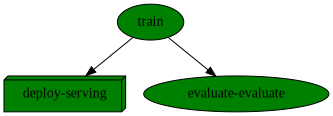

uid,start,state,name,parameters,results
...75d65066,Jan 24 13:47:54,completed,evaluate-evaluate,model_path=store://artifacts/sagemaker-payment-yoni/train_model_path@3e5b0616-330b-4112-b40b-6e9dfb018823model_name=xgboost-modeltest_set=s3://sagemaker-us-east-2-934638699319/payment-classification/test/test.csvlabel_column=transaction_category,
...8f39d8f1,Jan 24 13:41:12,completed,train,,


3e5b0616-330b-4112-b40b-6e9dfb018823

In [168]:
project.run(workflow_name,         
            watch=True,arguments={"evaluate_path": s3_data})